In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/PR_HW4/lfw.zip" -d "/content/drive/MyDrive/PR_HW4/lfw"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/PR_HW4/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/drive/MyDrive/PR_HW4/lfw/lfw/Recep_Tayyip_Erdogan/R

In [4]:
path = '/content/drive/MyDrive/PR_HW4/lfw/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print ("Cuda found.")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
  print ("MPS found.")
else:
  print ("Cuda or MPS device not found.")


Cuda found.


torch.Size([250, 250, 3])


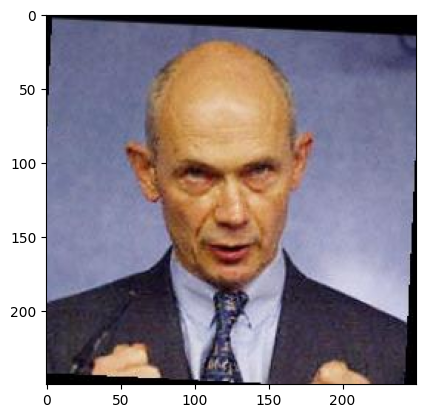

In [8]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Auto Encoders:** An autoencoder is a neural network designed for unsupervised learning, consisting of an encoder and a decoder. The encoder compresses input data into a lower-dimensional representation (latent space), and the decoder reconstructs the input from this representation.

**VAE:** A variational autoencoder extends the traditional autoencoder with a probabilistic approach. VAEs are generative models that not only learn a compressed representation but also model the distribution of the latent space

**Differences:**

**Applications:**
Autoencoders find their position in tasks like compressing data, removing noise, and reducing dimensions where as, Variational autoencoders shine in generating new data instances, employed for tasks like creating images, generating diverse datasets, and other creative applications.

**Architecture:**

Traditional autoencoders comprise an encoder and decoder, where the encoder maps input to a fixed-size latent space representation.

Variational autoencoders aslo share a similar structure but differ in that the encoder produces both the mean and variance of the latent space distribution, introducing a stochastic (probabilistic) element.

**Loss Function:**

Autoencoders typically employ a reconstruction loss like Mean Squared Error to gauge the dissimilarity between the input and the reconstructed output.

However, Variational autoencoders use a combination of a reconstruction loss and a KL (Kullback-Leibler) divergence term. The addition of the KL divergence encourages the learned latent space to adhere to a specific distribution (often Gaussian), serving as a regularization mechanism and ensuring the desired probability distribution in the latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [25]:
from torch.nn import functional as F

class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.encoder_conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Calculate the size of the flattened layer dynamically
        self._to_linear = None
        self.flatten((3, 250, 250))

        self.encoder_fc1 = nn.Linear(self._to_linear, 1024)
        self.encoder_fc21 = nn.Linear(1024, 20)
        self.encoder_fc22 = nn.Linear(1024, 20)

        # Decoder
        self.decoder_fc3 = nn.Linear(20, 1024)
        self.decoder_fc4 = nn.Linear(1024, 256 * 16 * 16)
        self.decoder_deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.decoder_deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def flatten(self, shape):
        with torch.no_grad():
            x = torch.ones(1, *shape)
            x = self.encoder_conv1(x)
            x = self.encoder_conv2(x)
            x = self.encoder_conv3(x)
            x = self.encoder_conv4(x)
            self._to_linear = x.view(-1).shape[0]

    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = F.relu(self.encoder_conv3(x))
        x = F.relu(self.encoder_conv4(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.encoder_fc1(x))
        return self.encoder_fc21(x), self.encoder_fc22(x)

    def decode(self, z):
        z = F.relu(self.decoder_fc3(z))
        z = F.relu(self.decoder_fc4(z))
        z = z.view(-1, 256, 16, 16)
        z = F.relu(self.decoder_deconv1(z))
        z = F.relu(self.decoder_deconv2(z))
        z = F.relu(self.decoder_deconv3(z))
        z = self.decoder_deconv4(z)

        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std




## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [10]:
input_image = torch.randn(1, 3, 250, 250).to(device)  # Example random image, adjust the size

vae_model = VAE().to(device)

output_recon, mu, logvar = vae_model(input_image)

epsilon = torch.randn_like(mu)
latent_sample = mu + epsilon * torch.exp(0.5 * logvar)

generated_image = vae_model.decode(latent_sample)

print("Shape of the output of the encoder:", mu.shape)
print("Shape of the generated image:", generated_image.shape)


Shape of the output of the encoder: torch.Size([1, 20])
Shape of the generated image: torch.Size([1, 3, 250, 250])


Here, the encoder output is [1, 20] 1 is batch size and 20 is size of the latent space.

The generated image which is after decoding is same as input image size.

The VAE's encoder outputs two vectors for each input: the mean vector (mu) and the logarithm of the variance vector (logvar).
These vectors represent the parameters of a multivariate Gaussian distribution in the latent space.
To generate a new sample, will draw a random sample latent_sample from this distribution. This is done by sampling from a standard normal distribution (N(0, 1)) and then transforming it using the mean and variance obtained from the encoder:

latent_sample = mu + epsilon * torch.exp(0.5 * logvar)

Here epsilon is random sample from the standard normal distribution

**Decoding:**
The sampled latent latent_sample vector will be passed through the decoder. The decoder transforms the latent vector back into the original data space.



##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [11]:
total_params = sum(p.numel() for p in vae_model.parameters())
print(f"Total number of parameters in the VAE model: {total_params}")


Total number of parameters in the VAE model: 127600363


**Loss Function for VAE:**

The loss function of a Variational Autoencoder (VAE) is composed of two essential terms the reconstruction loss and the KL divergence loss.

**Reconstruction Loss:**
Encourages the VAE to generate outputs resembling the input data.
In other words Quantifies the dissimilarity between the input and the reconstructed output.

Reconstruction Loss = (1/N) * ∑(i=1 to N) ∥xi - x̂i∥2

Here, N is the number of samples, xi is the input, and x̂i is the reconstructed output.

**KL Divergence Loss (Regularization Term):**
Regularizes the latent space, aligning it with a standard normal distribution.
In other words, Measures the divergence between the latent variable distribution and a standard normal distribution.

KL Divergence Loss = - (1/2) * ∑(i=1 to N) (1 + log(σi^2) - μi^2 - σi^2)

Here, N is the number of samples, μi and σi are the mean and standard deviation of the latent distribution.

**Explanation:**

The reconstruction loss ensures that the VAE generates outputs closely resembling the input data, promoting fidelity in reconstruction.

The KL divergence loss acts as a regularization term, guiding the latent space to adhere to a well-behaved distribution and preventing overfitting.

The total loss is often a combination of these terms, incorporating a weighting factor (β) for the KL divergence term:

Total Loss = Reconstruction Loss + β * KL Divergence Loss

Adjusting the value of β allows fine-tuning the balance between the importance of faithful reconstruction and regularization in the latent space.

* create an optimizer for training

In [12]:
import torch.optim as optim

learning_rate = 1e-3
weight_decay = 1e-5

optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [13]:
def vae_loss(output_recon, input_data, mu, logvar):
    reconstruction_loss = F.mse_loss(output_recon, input_data, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [14]:

optimizer.zero_grad()
output_recon, mu, logvar = vae_model(input_image)
loss = vae_loss(output_recon, input_image, mu, logvar)
loss.backward()
optimizer.step()


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [16]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0

    for i, (data, _) in enumerate(dataloader):
        input_image = data.to(device)
        optimizer.zero_grad()


        output_recon, mu, logvar = vae_model(input_image)

        loss = vae_loss(output_recon, input_image, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}')

Epoch [1/10], Loss: 215241.30159269323
Epoch [2/10], Loss: 157925.34233469202
Epoch [3/10], Loss: 149112.5317406401
Epoch [4/10], Loss: 144867.33048384663
Epoch [5/10], Loss: 141777.93019701086
Epoch [6/10], Loss: 138928.19819972827
Epoch [7/10], Loss: 135819.11337560386
Epoch [8/10], Loss: 132615.79142134663
Epoch [9/10], Loss: 129023.85446859903
Epoch [10/10], Loss: 125198.14388964372


In this model I've used around 10 epochs and after each epoch it was noticed that loss is decreasing.

If the loss is not decreasing we may have to do following troubleshooting steps:

**Learning Rate Adjustment:** We need to adjust the learning rate if it is too high or too low.

**Model Complexity:** Need to adjust the architecture of auto encoder.

**Data Quality:** Need to ensure that input data is properly preprocessed and free from any anomalies.

**Gradient Clipping:** We can also use gradient clipping to limit the gradient values during optimization.

**Early Stopping:** In order to eliminate overfitting we can stop the training if validation loss starts to increase.

By troubleshooting the above steps we can enhance the training performance of the autoencoder model.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

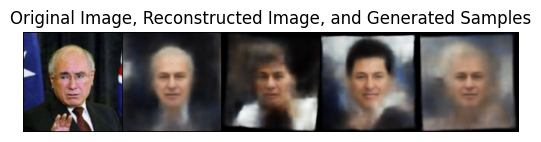

In [51]:
from torchvision.utils import make_grid

def plot_images(images, title):
    img_grid = make_grid(images.detach().cpu(), nrow=5, normalize=True)
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

random_index = torch.randint(0, len(dataloader.dataset), size=(1,)).item()
original_image, _ = dataloader.dataset[random_index]
original_image = original_image.unsqueeze(0).to(device)

reconstructed_image, mu, logvar = vae_model(original_image)
latent_samples = torch.randn(3, mu.size(1)).to(device)
generated_images = vae_model.decode(latent_samples)

images_to_plot = torch.cat([original_image, reconstructed_image, generated_images], dim=0)
plot_images(images_to_plot, "Original Image, Reconstructed Image, and Generated Samples")
